Back Translation


In [ ]:
!pip install google_trans_new

In [ ]:
!pip install googletrans

Back Translation


In [ ]:
import random
import googletrans
from google_trans_new import google_translator

translator = google_translator()

def back_translate(sentence):
  available_langs = list(googletrans.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")
  translations = translator.translate(sentence, lang_tgt=trans_lang) 
  print(translations)
  en_text = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
  print(en_text)
  return en_text


Random Swap


In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

Random Deletion

In [ ]:
def random_deletion(words, p=0.5): 
    print(len(words))
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    print(remaining)
    rema=' '.join(remaining)
    print(rema)
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return rema

In [ ]:
def remove_stopwords(input_text):
    stopwords_list = ['the','a','an','/','.','of','is','+','another','for','yet','or','and']
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1] 
    return " ".join(clean_words) 

In [ ]:
import pandas as pd
!pip install pytreebank

In [ ]:
import torch

In [ ]:
import pytreebank
import sys
import os


In [ ]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

In [ ]:
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [ ]:
import pandas as pd

In [ ]:
df1=pd.read_csv('./sst_train.txt',sep='\t',header=None,names=['label','text']) # reading the training set data

In [ ]:
df2=pd.read_csv('./sst_test.txt',sep='\t',header=None,names=['label','text']) # reading the test set data

In [ ]:
df3=pd.read_csv('./sst_dev.txt',sep='\t',header=None,names=['label','text']) # reading the validation set data

In [ ]:
df1['label']=df1['label'].str.replace('__label__','')
df2['label']=df2['label'].str.replace('__label__','')
df3['label']=df3['label'].str.replace('__label__','')


# Data sets
Before the creating the datasets where the text is tokenized etc, the data sets were augmented, using back translation, random insertion, random swap and/or random deletion.
Since te distribution of classes is not balanced, I decided to augment the data in such a way so that sentences for a particular label are more or less equal in number.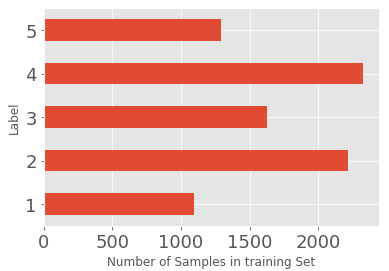

It is clear that most of the training samples belong to classes 2 and 4 (the weakly negative/positive classes). A sizeable number of samples belong to the neutral class. Barely 12% of the samples are from the strongly negative class 1 and same is the case for class 5.
Code below is to pick up sentences belonging to class 1 and 5 and create some more using back translation.

In [ ]:
sentences1=[t for t in df1.text[df1.label=='1']]


In [ ]:
ts=[]
i=0
for s in sentences1[:10]:
  #s=[s]
  print(s)
  t1=back_translate(s)
  print(t1)
  df=pd.DataFrame([['1',t1]], columns=['label','text'])
  #ts=ts.append(t1)
  ts.append(t1)
  i=i+1
  df1=df1.append(df, ignore_index=True)

In [ ]:
len(df1)

8554

In [ ]:
for s in sentences1[10:900]:
  t1=back_translate(s)
  #print (t1)
  df=pd.DataFrame([['1',t1]], columns=['label','text'])
  #ts=ts.append(t1)
  ts.append(t1)
  df1=df1.append(df, ignore_index=True)

In [ ]:
df1.label.value_counts()

4    2322
2    2218
5    2087
1    1724
3    1624
Name: label, dtype: int64

So now examples for label 1 are more or less in the range of other classes. Now Class 5 examples to be handled. So I am going to do the same back translation to increase the examples of label 5.

In [ ]:
sentences5=[t for t in df1.text[df1.label=='5']]

In [ ]:
for s in sentences5[1:800]:
  t1=back_translate(s)
  #print (t1)
  df=pd.DataFrame([['5',t1]], columns=['label','text'])
  #ts=ts.append(t1)
  ts.append(t1)
  df1=df1.append(df, ignore_index=True)

In [ ]:
len(df1)

9975

Further some more augmentation was done using stop word removal and random deletion. For this I chose some examples from class 3 and 5.

In [ ]:
import random
random.seed(43)
s=sentences5[0]
s=s.split()
print(s)
t1=random_deletion(s, p=0.5)
print(t1)
df5=pd.DataFrame([['5',t1]], columns=['label','text'])
for s in sentences5[1:50]:
  s=s.split()
  t1=random_deletion(s, p=0.5)
  dfn=pd.DataFrame([['5',t1]], columns=['label','text'])
  df5=df5.append(dfn, ignore_index=True)

In [ ]:
sentences3=[t for t in df1.text[df1.label=='3']]
s=sentences3[0]
t1=remove_stopwords(s)
df=pd.DataFrame([['3',t1]], columns=['label','text'])
for s in sentences3[1:200]:
  t1=remove_stopwords(s)
  dfn=pd.DataFrame([['3',t1]], columns=['label','text'])
  df=df.append(dfn, ignore_index=True)

In [ ]:
import random
import torch, torchtext
from torchtext import data

In [ ]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [ ]:
Review_text= torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [ ]:
fields = [('review',Review_text),('label',Label)]

In [ ]:
train_example = [torchtext.legacy.data.Example.fromlist([df1.text[i],df1.label[i]], fields) for i in range(df1.shape[0])] 

In [ ]:
train_set=torchtext.legacy.data.Dataset(train_example,fields)

In [ ]:
Review_text.build_vocab(train_set)
Label.build_vocab(train_set)

In [ ]:
print('Size of input vocab : ', len(Review_text.vocab))
print('Size of label vocab : ', len(Label.vocab))

Size of input vocab :  18489
Size of label vocab :  5


In [ ]:
Label.vocab.itos

['4', '2', '5', '1', '3']

In [ ]:
Label.vocab.stoi

defaultdict(None, {'1': 3, '2': 1, '3': 4, '4': 0, '5': 2})

In [ ]:
test_example = [torchtext.legacy.data.Example.fromlist([df2.text[i],df2.label[i]], fields) for i in range(df2.shape[0])] 
val_example = [torchtext.legacy.data.Example.fromlist([df3.text[i],df3.label[i]], fields) for i in range(df3.shape[0])] 

In [ ]:
#(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))
#train_set=sentimentDataset

In [ ]:
test_set=torchtext.legacy.data.Dataset(test_example,fields)
val_set=torchtext.legacy.data.Dataset(val_example,fields)

In [ ]:
len(train_set),len(test_set),len(val_set)

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    #pickle.dump(Tweet.vocab.stoi, tokens)
    pickle.dump(Review_text.vocab.stoi,tokens)

In [ ]:
f1=open('trainset.pkl','wb')
pickle.dump(list(train_set),f1)
f1.close()

In [ ]:
with open('trainset.pkl','wb') as f1:
  pickle.dump(list(train_set),f1)
f1.close()

In [ ]:
with open('testset.pkl','wb') as f2:
  pickle.dump(list(test_set),f2)
f2.close()


In [ ]:
with open('valset.pkl','wb') as f1:
  pickle.dump(list(val_set),f1)
f1.close()

In [ ]:
from google.colab import files

In [ ]:
files.download('trainset_new.pkl')

In [ ]:
files.download('testset.pkl')

In [ ]:
files.download('valset.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>